In [166]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [167]:
import torch
import polars as pl
from torch.utils.data import DataLoader, Dataset
import torch_geometric
from torch_geometric.data import Data, Dataset
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Upload the data

In [168]:
def load_data(source) -> pl.DataFrame:
    return pl.read_csv(source = source, truncate_ragged_lines = True)

In [169]:
#Load the data
train_sequences = load_data(source = "/home/mich02/Desktop/Kaggle/data/train_sequences.csv")
train_labels = load_data(source = "/home/mich02/Desktop/Kaggle/data/train_labels.csv")
test_sequences = load_data(source = "/home/mich02/Desktop/Kaggle/data/test_sequences.csv")
valid_sequences = load_data(source = "/home/mich02/Desktop/Kaggle/data/validation_sequences.csv")
valid_labels = load_data(source = "/home/mich02/Desktop/Kaggle/data/validation_labels.csv")
sample_submission = load_data(source = "/home/mich02/Desktop/Kaggle/data/sample_submission.csv")

#Check for N/A
datasets = {
    "Train Sequences": train_sequences,
    "Train Labels": train_labels,
    "Test Sequences": test_sequences,
    "Validation Sequences": valid_sequences,
    "Validation Labels": valid_labels,
}

for name, df in datasets.items():
    null_counts = df.null_count().sum()
    print(f"N/A count for {name}: {null_counts}")

N/A count for Train Sequences: shape: (1, 5)
┌───────────┬──────────┬─────────────────┬─────────────┬───────────────┐
│ target_id ┆ sequence ┆ temporal_cutoff ┆ description ┆ all_sequences │
│ ---       ┆ ---      ┆ ---             ┆ ---         ┆ ---           │
│ u32       ┆ u32      ┆ u32             ┆ u32         ┆ u32           │
╞═══════════╪══════════╪═════════════════╪═════════════╪═══════════════╡
│ 0         ┆ 0        ┆ 0               ┆ 0           ┆ 5             │
└───────────┴──────────┴─────────────────┴─────────────┴───────────────┘
N/A count for Train Labels: shape: (1, 6)
┌─────┬─────────┬───────┬──────┬──────┬──────┐
│ ID  ┆ resname ┆ resid ┆ x_1  ┆ y_1  ┆ z_1  │
│ --- ┆ ---     ┆ ---   ┆ ---  ┆ ---  ┆ ---  │
│ u32 ┆ u32     ┆ u32   ┆ u32  ┆ u32  ┆ u32  │
╞═════╪═════════╪═══════╪══════╪══════╪══════╡
│ 0   ┆ 0       ┆ 0     ┆ 6145 ┆ 6145 ┆ 6145 │
└─────┴─────────┴───────┴──────┴──────┴──────┘
N/A count for Test Sequences: shape: (1, 5)
┌───────────┬──────────┬─────

In [170]:
#Fill the N/A with 0 
train_sequences = train_sequences.drop_nulls()
print(train_sequences)


shape: (839, 5)
┌───────────┬──────────────────────┬─────────────────┬──────────────────────┬──────────────────────┐
│ target_id ┆ sequence             ┆ temporal_cutoff ┆ description          ┆ all_sequences        │
│ ---       ┆ ---                  ┆ ---             ┆ ---                  ┆ ---                  │
│ str       ┆ str                  ┆ str             ┆ str                  ┆ str                  │
╞═══════════╪══════════════════════╪═════════════════╪══════════════════════╪══════════════════════╡
│ 1SCL_A    ┆ GGGUGCUCAGUACGAGAGGA ┆ 1995-01-26      ┆ THE SARCIN-RICIN     ┆ >1SCL_1|Chain A|RNA  │
│           ┆ ACCGCACCC            ┆                 ┆ LOOP, A MODUL…       ┆ SARCIN-RIC…          │
│ 1RNK_A    ┆ GGCGCAGUGGGCUAGCGCCA ┆ 1995-02-27      ┆ THE STRUCTURE OF AN  ┆ >1RNK_1|Chain A|RNA  │
│           ┆ CUCAAAAGGC…          ┆                 ┆ RNA PSEUDO…          ┆ PSEUDOKNOT…          │
│ 1RHT_A    ┆ GGGACUGACGAUCACGCAGU ┆ 1995-06-03      ┆ 24-MER RNA HAIRPIN  

In [171]:
train_labels = train_labels.drop_nulls()
print(train_labels)

shape: (130_950, 6)
┌───────────┬─────────┬───────┬────────────┬────────────┬────────────┐
│ ID        ┆ resname ┆ resid ┆ x_1        ┆ y_1        ┆ z_1        │
│ ---       ┆ ---     ┆ ---   ┆ ---        ┆ ---        ┆ ---        │
│ str       ┆ str     ┆ i64   ┆ f64        ┆ f64        ┆ f64        │
╞═══════════╪═════════╪═══════╪════════════╪════════════╪════════════╡
│ 1SCL_A_1  ┆ G       ┆ 1     ┆ 13.76      ┆ -25.974001 ┆ 0.102      │
│ 1SCL_A_2  ┆ G       ┆ 2     ┆ 9.31       ┆ -29.638    ┆ 2.669      │
│ 1SCL_A_3  ┆ G       ┆ 3     ┆ 5.529      ┆ -27.813    ┆ 5.878      │
│ 1SCL_A_4  ┆ U       ┆ 4     ┆ 2.678      ┆ -24.900999 ┆ 9.793      │
│ 1SCL_A_5  ┆ G       ┆ 5     ┆ 1.827      ┆ -20.136    ┆ 11.793     │
│ …         ┆ …       ┆ …     ┆ …          ┆ …          ┆ …          │
│ 8Z1F_T_62 ┆ U       ┆ 62    ┆ 112.516998 ┆ 117.880997 ┆ 119.245003 │
│ 8Z1F_T_63 ┆ A       ┆ 63    ┆ 115.292999 ┆ 116.571999 ┆ 114.827003 │
│ 8Z1F_T_64 ┆ C       ┆ 64    ┆ 115.857002 ┆ 114.595001 ┆

In [172]:
#Verifying the shape
print(f'The shapes of train data, train targets, test data are \n {train_sequences.shape}, {train_labels.shape}, {test_sequences.shape}')

The shapes of train data, train targets, test data are 
 (839, 5), (130950, 6), (12, 5)


In [173]:
train_sequences = train_sequences.drop(["temporal_cutoff", "description", "all_sequences"])
test_sequences = test_sequences.drop(["description", "all_sequences"])

In [174]:
print(valid_sequences)

shape: (12, 5)
┌───────────┬──────────────────────┬─────────────────┬──────────────────────┬──────────────────────┐
│ target_id ┆ sequence             ┆ temporal_cutoff ┆ description          ┆ all_sequences        │
│ ---       ┆ ---                  ┆ ---             ┆ ---                  ┆ ---                  │
│ str       ┆ str                  ┆ str             ┆ str                  ┆ str                  │
╞═══════════╪══════════════════════╪═════════════════╪══════════════════════╪══════════════════════╡
│ R1107     ┆ GGGGGCCACAGCAGAAGCGU ┆ 2022-05-28      ┆ CPEB3 ribozyme       ┆ >7QR4_1|Chain A|U1   │
│           ┆ UCACGUCGCA…          ┆                 ┆ Human                ┆ small nucle…         │
│           ┆                      ┆                 ┆ human CPE…           ┆                      │
│ R1108     ┆ GGGGGCCACAGCAGAAGCGU ┆ 2022-05-27      ┆ CPEB3 ribozyme       ┆ >7QR3_1|Chains A,    │
│           ┆ UCACGUCGCG…          ┆                 ┆ Chimpanzee           

In [175]:
valid_labels = valid_labels.select(["ID", "resname", "resid", "x_1", "y_1", "z_1"]) 
print(valid_labels)

shape: (2_515, 6)
┌───────────┬─────────┬───────┬────────────┬────────────┬────────────┐
│ ID        ┆ resname ┆ resid ┆ x_1        ┆ y_1        ┆ z_1        │
│ ---       ┆ ---     ┆ ---   ┆ ---        ┆ ---        ┆ ---        │
│ str       ┆ str     ┆ i64   ┆ f64        ┆ f64        ┆ f64        │
╞═══════════╪═════════╪═══════╪════════════╪════════════╪════════════╡
│ R1107_1   ┆ G       ┆ 1     ┆ -5.499     ┆ 8.52       ┆ 8.605      │
│ R1107_2   ┆ G       ┆ 2     ┆ -5.826     ┆ 10.453     ┆ 14.01      │
│ R1107_3   ┆ G       ┆ 3     ┆ -5.849     ┆ 14.768     ┆ 17.584999  │
│ R1107_4   ┆ G       ┆ 4     ┆ -5.784     ┆ 19.985001  ┆ 18.666     │
│ R1107_5   ┆ G       ┆ 5     ┆ -5.755     ┆ 25.533001  ┆ 17.132999  │
│ …         ┆ …       ┆ …     ┆ …          ┆ …          ┆ …          │
│ R1190_114 ┆ U       ┆ 114   ┆ 87.870003  ┆ 105.432999 ┆ 115.183998 │
│ R1190_115 ┆ U       ┆ 115   ┆ 92.911003  ┆ 105.394997 ┆ 113.741997 │
│ R1190_116 ┆ U       ┆ 116   ┆ 99.012001  ┆ 105.749001 ┆ 1

## Visualize

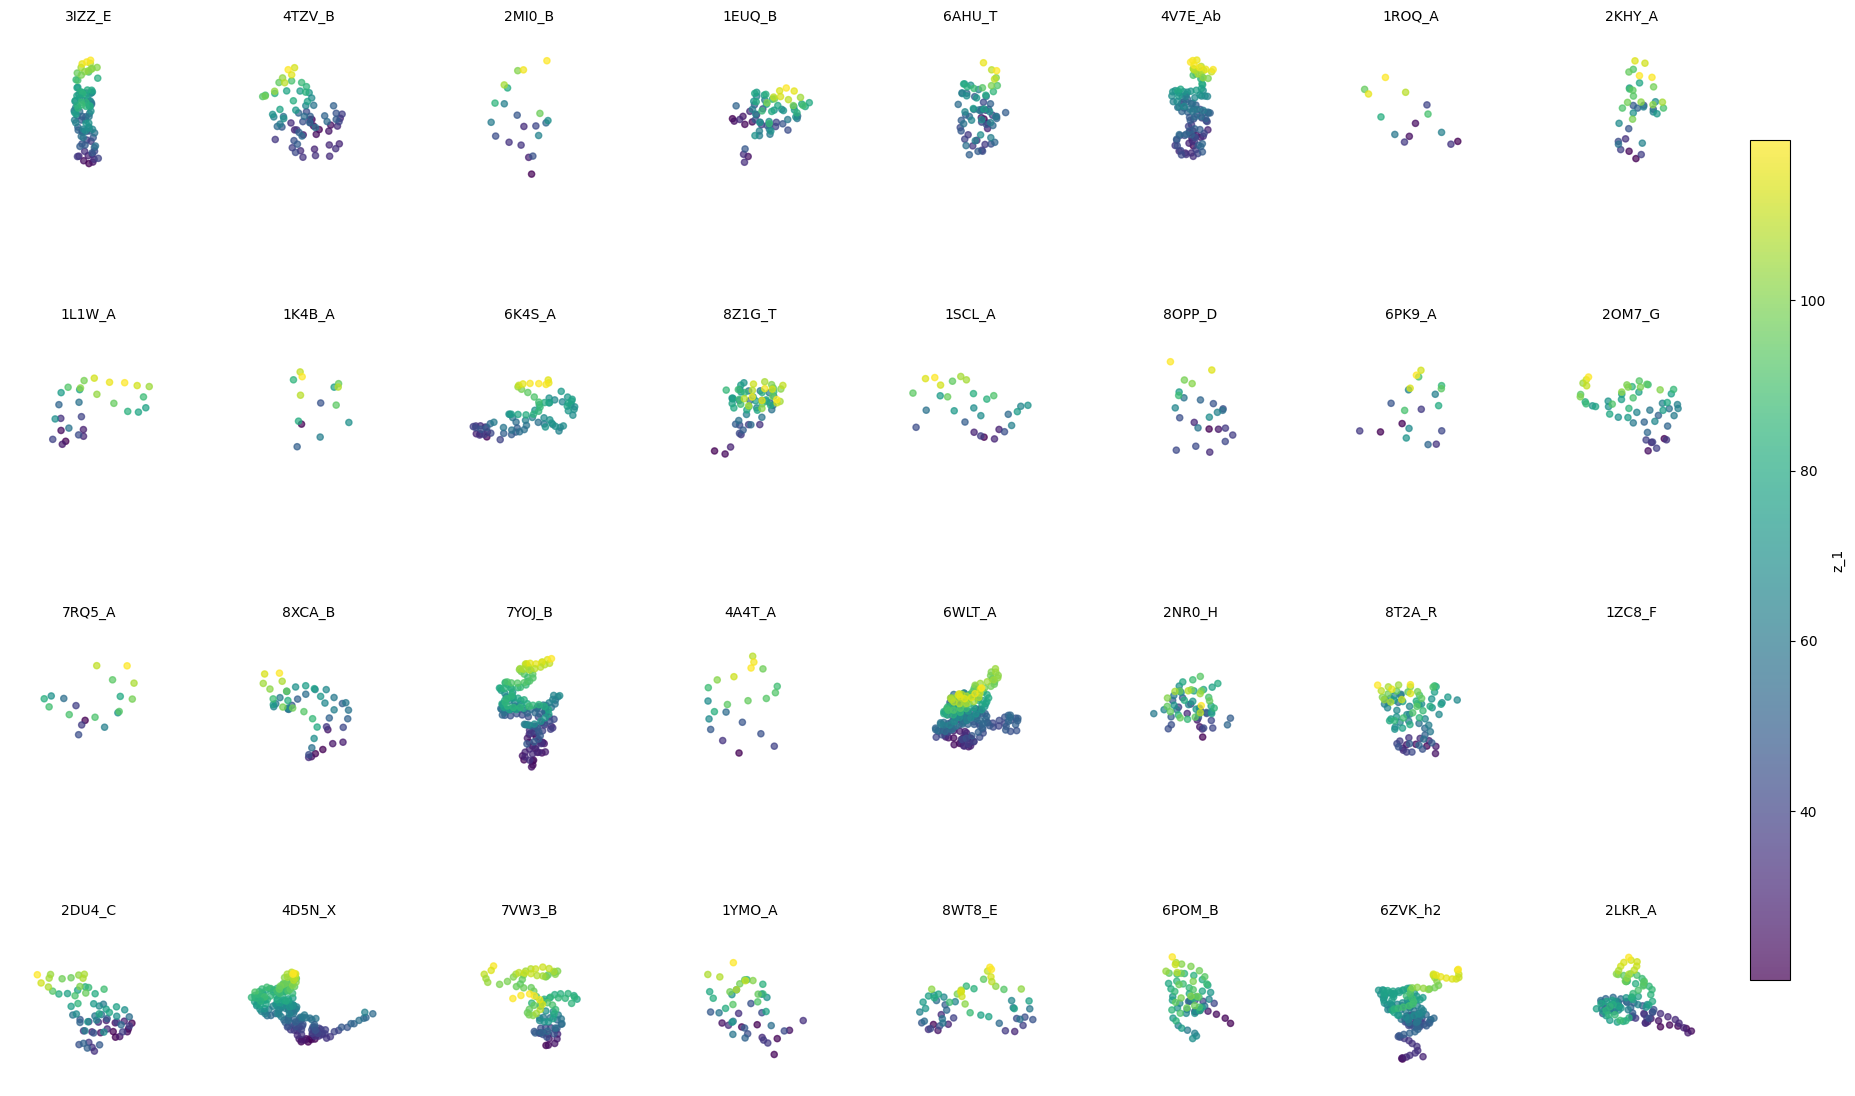

In [176]:
np.random.seed(42)

#Get unique target IDs
unique_target_ids = train_sequences['target_id'].unique().to_list()

#Randomly select 32 target IDs
idx = np.random.choice(len(unique_target_ids), size=32, replace=False)
selected_target_ids = [unique_target_ids[i] for i in idx]

#Create a figure with 4x8 subplots for 3D scatter plots
fig, axes = plt.subplots(4, 8, figsize=(20, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

#Visualize sample data in 3D scatter plots
for i, target_id in enumerate(selected_target_ids):
    axes[i].axis('off')  #Hide axis ticks
    
    #Get all labels corresponding to the current target_id
    filtered_data = train_labels.filter(pl.col('ID').str.starts_with(target_id)).sort('resid').to_dict(as_series=False)
    
    #Extract coordinates and residue names
    x = np.array(filtered_data['x_1'], dtype=float)
    y = np.array(filtered_data['y_1'], dtype=float)
    z = np.array(filtered_data['z_1'], dtype=float)
    
    #Create 3D scatter plot
    sc = axes[i].scatter(x, y, z, c=z, cmap='viridis', alpha=0.7)
    
    #Set view angle
    axes[i].view_init(elev=30, azim=45)
    
    #Set title
    axes[i].set_title(f'{target_id}', color='black', fontsize=10, pad=10)

#Add a colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) 
fig.colorbar(sc, cax=cbar_ax, label='z_1', orientation='vertical')

#Adjust layout
fig.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.4, hspace=0.6)

#Show the plot
plt.show()

## Graph neural network and Diffusion model

****1. Preprocessing: Convert squence to graph****

In [177]:
nucleotide_map ={"A": [1, 0, 0, 0],
                 "U": [0, 1, 0, 0],
                 "G": [0, 0, 1, 0],
                 "C": [0, 0, 0, 1]}

# One-hot encoding of nucleotides
def sequence_to_graph(rna_sequence: str) -> Data:
    node_features = torch.tensor([nucleotide_map.get(nuc, [0, 0, 0, 0]) for nuc in rna_sequence], dtype = torch.float)
    edge_index = torch.tensor([[i, i + 1] for i in range(len(rna_sequence) - 1)], dtype = torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim = 1)
    return Data(x = node_features, edge_index = edge_index)

print(sequence_to_graph(rna_sequence = train_sequences[0,1]))

Data(x=[29, 4], edge_index=[2, 56])


**2. Create a Data Loader**

In [178]:
class RNA_Graph_Dataset(Dataset):
    def __init__(self, sequences: pl.DataFrame, labels: pl.DataFrame):
        self.sequences = sequences
        self.labels = labels

        # Create target_id column for labels
        if "target_id" not in self.labels.columns:
            self.labels = self.labels.with_columns([
                (pl.col("ID").str.split("_").list.get(0)).alias("target_id")
            ])

        # Create target_id column for sequences if not exist
        if "target_id" not in self.sequences.columns:
            raise ValueError("Sequences must have a 'target_id' column!")

        # Only keep sequences whose target_id exists in labels
        valid_ids = self.labels.select("target_id").unique().get_column("target_id")
        self.sequences = self.sequences.filter(
            pl.col("target_id").is_in(valid_ids)
        )

        self.seq_rows = self.sequences.rows(named=True)
        super().__init__()

    def __len__(self):
        return len(self.seq_rows)

    def __getitem__(self, idx):
        row = self.seq_rows[idx]
        target_id = row["target_id"]
        sequence = row["sequence"]

        graph = sequence_to_graph(sequence)

        label_rows = self.labels.filter(pl.col("target_id") == target_id).sort("resid")
        coords = torch.tensor(label_rows.select(["x_1", "y_1", "z_1"]).to_numpy(), dtype=torch.float)

        assert coords.shape[0] == graph.x.shape[0], f"Mismatch in length for {target_id}"
        graph.y = coords
        graph.target_id = target_id
        return graph


In [179]:
# TRAIN
if "target_id" not in train_labels.columns:
    train_labels = train_labels.with_columns([
        (pl.col("ID").str.split("_").list.get(0) + "_" + pl.col("ID").str.split("_").list.get(1)).alias("target_id")
    ])

# VALID
if "target_id" not in valid_labels.columns:
    valid_labels = valid_labels.with_columns([
        (pl.col("ID").str.split("_").list.get(0)).alias("target_id")
    ])


In [180]:
train_dataset = RNA_Graph_Dataset(train_sequences, train_labels)
valid_dataset = RNA_Graph_Dataset(valid_sequences, valid_labels)

print(len(train_dataset))
print(len(valid_dataset))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)


793
12


In [181]:
train_dataset = RNA_Graph_Dataset(train_sequences, train_labels)

# Print the first sample
train_sample = train_dataset[0]
print(train_sample)
print(f"Node features shape: {train_sample.x.shape}")        # Node features
print(f"Coordinates shape: {train_sample.y.shape}")        # 3D coordinates
print(f"Edge index shape: {train_sample.edge_index}")     # Graph edges
print(f"Target ID: {train_sample.target_id}")      # String ID

Data(x=[29, 4], edge_index=[2, 56], y=[29, 3], target_id='1SCL_A')
Node features shape: torch.Size([29, 4])
Coordinates shape: torch.Size([29, 3])
Edge index shape: tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22, 23, 24, 25, 26, 27,  1,  2,  3,  4,  5,  6,  7,  8,
          9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
         27, 28],
        [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  0,  1,  2,  3,  4,  5,  6,  7,
          8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
         26, 27]])
Target ID: 1SCL_A


In [182]:
valid_dataset = RNA_Graph_Dataset(valid_sequences, valid_labels)

print(f"Validation dataset size: {len(valid_dataset)} samples")

valid_sample = valid_dataset[0]

print(valid_sample)
print(f"Node features shape: {valid_sample.x.shape}")  # should be (N, 4)
print(f"Coordinates shape: {valid_sample.y.shape}")    # should be (N, 3)
print(f"Edge index shape: {valid_sample.edge_index.shape}") # (2, number_of_edges)
print(f"Target ID: {valid_sample.target_id}")


Validation dataset size: 12 samples
Data(x=[69, 4], edge_index=[2, 136], y=[69, 3], target_id='R1107')
Node features shape: torch.Size([69, 4])
Coordinates shape: torch.Size([69, 3])
Edge index shape: torch.Size([2, 136])
Target ID: R1107


**Model Achitecture**

We will use GNN to generate node embeddings and use SE(3)-Transformers to iteratively refine/predict 3d positions

In [183]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import polars as pl
from tqdm import tqdm


In [184]:
from egnn_pytorch import EGNN
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GNNStructRNA_EGNN(nn.Module):
    def __init__(self, node_feat_dim=4, gnn_hidden=64, egnn_dim=64, num_egnn_layers=4):
        super().__init__()
        self.conv1 = GCNConv(node_feat_dim, gnn_hidden)
        self.relu1 = nn.ReLU()
        self.conv2 = GCNConv(gnn_hidden, egnn_dim)
        self.relu2 = nn.ReLU()

        self.egnn_layers = nn.ModuleList([
            EGNN(
                dim=egnn_dim,
                edge_dim=0,        # <--- fixed here!
                norm_coors=True
            ) for _ in range(num_egnn_layers)
        ])

        self.to_3d = nn.Linear(egnn_dim, 3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        h = self.conv1(x, edge_index)
        h = self.relu1(h)
        h = self.conv2(h, edge_index)
        h = self.relu2(h)

        pos = torch.randn((h.size(0), 3), device=h.device)

        # Add batch dimension
        h = h.unsqueeze(0)  # (1, N, F)
        pos = pos.unsqueeze(0)  # (1, N, 3)

        for egnn_layer in self.egnn_layers:
            h, pos = egnn_layer(h, pos, edges = None)

        # Remove batch dimension
        h = h.squeeze(0)
        pos = pos.squeeze(0)

        refined_pos = self.to_3d(h)
        return refined_pos


In [185]:

def compute_losses(pred_coords, true_coords, distogram_weight=0.5):
    mse_loss = nn.functional.mse_loss(pred_coords, true_coords)
    dist_pred = torch.cdist(pred_coords, pred_coords)
    dist_true = torch.cdist(true_coords, true_coords)
    dist_loss = nn.functional.mse_loss(dist_pred, dist_true)
    return mse_loss + distogram_weight * dist_loss



In [186]:
from torch_geometric.loader import DataLoader as GeoDataLoader
from tqdm import tqdm

# --- Hyperparameters ---
BATCH_SIZE = 1
LR = 2e-4
EPOCHS = 50
DISTOGRAM_WEIGHT = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Prepare Datasets ---
train_dataset = RNA_Graph_Dataset(train_sequences, train_labels)
valid_dataset = RNA_Graph_Dataset(valid_sequences, valid_labels)

train_loader = GeoDataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = GeoDataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [187]:

# --- Initialize Model, Optimizer, Scheduler ---
model = GNNStructRNA_EGNN(
    node_feat_dim=4,
    gnn_hidden=64,
    egnn_dim=64,
    num_egnn_layers=4
).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.amp.GradScaler("cuda")

In [188]:

# --- Training + Validation ---
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f'Train Epoch {epoch+1}/{EPOCHS}'):
        batch = batch.to(DEVICE)
        optimizer.zero_grad()

        with torch.autocast(device_type = "cuda"):
            pred_coords = model(batch)
            loss = compute_losses(pred_coords, batch.y, distogram_weight=DISTOGRAM_WEIGHT)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    scheduler.step()

    # --- Validation ---
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(valid_loader, desc=f'Valid Epoch {epoch+1}/{EPOCHS}'):
            batch = batch.to(DEVICE)

            with torch.autocast(device_type = "cuda"):
                pred_coords = model(batch)
                loss = compute_losses(pred_coords, batch.y, distogram_weight=DISTOGRAM_WEIGHT)

            valid_loss += loss.item() 

    avg_train_loss = train_loss / len(train_loader)
    avg_valid_loss = valid_loss / len(valid_loader)

    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.6f} | Valid Loss: {avg_valid_loss:.6f}')

    # --- Save checkpoint ---
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pt")

print("Training and Validation complete!")


Train Epoch 1/50:   1%|          | 5/793 [00:00<00:06, 119.63it/s]


AssertionError: Mismatch in length for 8WT7_E